<a href="https://colab.research.google.com/github/Jahaziel4587/PDI_2025/blob/main/PIA_RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
39/39 - 130s - 3s/step - accuracy: 0.5086 - auc: 0.4912 - loss: 0.7035 - val_accuracy: 0.5161 - val_auc: 0.5880 - val_loss: 0.6924
Epoch 2/30
39/39 - 115s - 3s/step - accuracy: 0.5135 - auc: 0.4745 - loss: 0.6948 - val_accuracy: 0.5161 - val_auc: 0.5065 - val_loss: 0.6926
Epoch 3/30
39/39 - 121s - 3s/step - accuracy: 0.5184 - auc: 0.5114 - loss: 0.6925 - val_accuracy: 0.5161 - val_auc: 0.5781 - val_loss: 0.6918
Epoch 4/30
39/39 - 122s - 3s/step - accuracy: 0.5143 - auc: 0.4869 - loss: 0.6934 - val_accuracy: 0.5161 - val_auc: 0.5586 - val_loss: 0.6922
Epoch 5/30
39/39 - 112s - 3s/step - accuracy: 0.5143 - auc: 0.4897 - loss: 0.6932 - val_accuracy: 0.5161 - val_auc: 0.5786 - val_loss: 0.6923
Epoch 6/30
39/39 - 125s - 3s/step - accuracy: 0.5143 - auc: 0.4793 - loss: 0.6932 - val_accuracy: 0.5161 - val_auc: 0.5344 - val_loss: 0.6919
Epoch 7/30
39/39 - 121s - 3s/step - accuracy: 0.5151 - auc: 0.5224 - loss: 0.6924 - val_accuracy: 0.5161 - val_auc: 0.5962 - val_loss: 0.6904
Epoch 

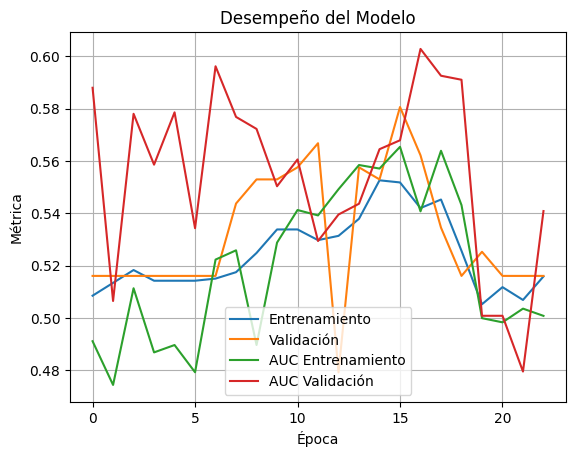

In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Ruta del dataset en tu Drive
dataset_path = "/content/drive/MyDrive/MAMOGRAFIAS"
img_height, img_width = 227, 227

def load_images_from_folders(base_path):
    images, labels = [], []
    for label_dir in ['benign', 'malignant']:
        label = 0 if label_dir == 'benign' else 1
        path = os.path.join(base_path, label_dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_width, img_height))
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                img = clahe.apply(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images_from_folders(dataset_path)
images = images.reshape(-1, img_height, img_width, 1) / 255.0

# División en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

# Aumento de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Definición del modelo CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stop],
    verbose=2
)

# Evaluación
val_preds = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, val_preds, target_names=['Benigno', 'Maligno']))

# Gráfica
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.plot(history.history['auc'], label='AUC Entrenamiento')
plt.plot(history.history['val_auc'], label='AUC Validación')
plt.xlabel('Época')
plt.ylabel('Métrica')
plt.legend()
plt.grid(True)
plt.title('Desempeño del Modelo')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


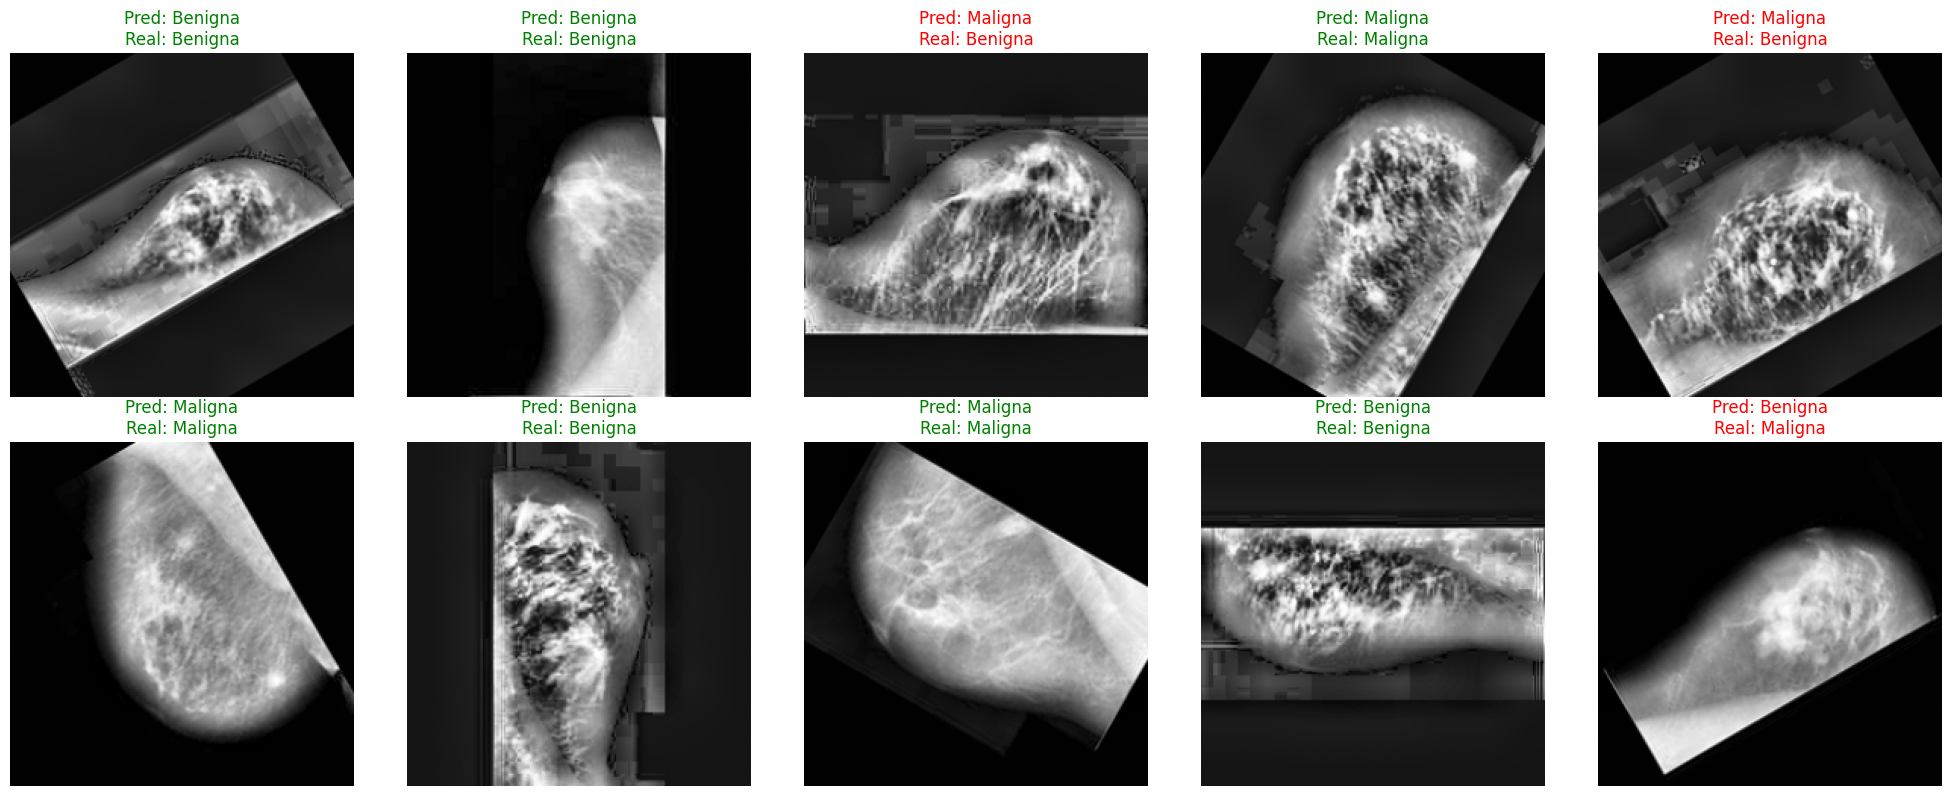

In [3]:
# Visualización de 10 predicciones del modelo sobre imágenes de validación

# Seleccionar 10 imágenes al azar del conjunto de validación
num_images = 10
indices = np.random.choice(len(X_val), num_images, replace=False)
sample_images = X_val[indices]
sample_labels = y_val[indices]

# Predecir las clases
predictions = model.predict(sample_images)

# Mostrar imágenes con etiquetas reales y predichas
plt.figure(figsize=(20, 8))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].reshape(img_height, img_width), cmap='gray')
    pred_label = "Maligna" if predictions[i] > 0.5 else "Benigna"
    true_label = "Maligna" if sample_labels[i] == 1 else "Benigna"
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'Pred: {pred_label}\nReal: {true_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()
